<a href="https://colab.research.google.com/github/AZoyaV/Python/blob/main/Exploratory_data_analysis_for_global_sales_offline_online_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data overview

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/Mate_homework


products = pd.read_csv("products.csv")
countries = pd.read_csv("countries.csv")
events = pd.read_csv("events.csv")

# Огляд даних
print("Products:", products.shape)
print(products.head())

print("Countries:", countries.shape)
print(countries.head())

print("Events:", events.shape)
print(events.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Mate_homework
Products: (12, 2)
     id        item_type
0  2103           Cereal
1  7940        Household
2  2455          Clothes
3  1270        Beverages
4  8681  Office Supplies
Countries: (249, 5)
             name alpha-2 alpha-3   region       sub-region
0     Afghanistan      AF     AFG     Asia    Southern Asia
1   Åland Islands      AX     ALA   Europe  Northern Europe
2         Albania      AL     ALB   Europe  Southern Europe
3         Algeria      DZ     DZA   Africa  Northern Africa
4  American Samoa      AS     ASM  Oceania        Polynesia
Events: (1330, 10)
    Order ID Order Date   Ship Date Order Priority Country Code  Product ID  \
0  100640618  10/8/2014  10/18/2014              M          NOR        2103   
1  100983083  8/11/2016   8/11/2016              C          SRB        2103   
2  101025998  7/18/2014   8/11

## Перша таблиця надає нам дані ID продукту і сам тип продукту. Друга таблиця надає дані по країнам. Третя таблиця має дані кількості продажів, ціни, витрати на закупівлю та тип каналу продажів. Ключові колонки, що обєднують усі три таблиці: id (Products) = Product ID (Events), alfa-3 (Country) = Country Code (Events).

# Data cleaning

In [ ]:
# Перевірка пропущених значень
print(products.isna().sum())
print(countries.isna().sum())
print(events.isna().sum())

# Доля пропущених значень від загальної кількості
print(products.isna().sum() / products.shape[0] * 100)
print(countries.isna().sum() / countries.shape[0] * 100)
print(events.isna().sum() / events.shape[0] * 100)

# Що саме пропущено у alpha-2
print(countries[countries.isna().any(axis=1)])

id           0
item_type    0
dtype: int64
name          0
alpha-2       1
alpha-3       0
region        1
sub-region    1
dtype: int64
Order ID           0
Order Date         0
Ship Date          0
Order Priority     0
Country Code      82
Product ID         0
Sales Channel      0
Units Sold         2
Unit Price         0
Unit Cost          0
dtype: int64
id          0.00
item_type   0.00
dtype: float64
name         0.00
alpha-2      0.40
alpha-3      0.00
region       0.40
sub-region   0.40
dtype: float64
Order ID         0.00
Order Date       0.00
Ship Date        0.00
Order Priority   0.00
Country Code     6.17
Product ID       0.00
Sales Channel    0.00
Units Sold       0.15
Unit Price       0.00
Unit Cost        0.00
dtype: float64
           name alpha-2 alpha-3  region          sub-region
8    Antarctica      AQ     ATA     NaN                 NaN
153     Namibia     NaN     NAM  Africa  Sub-Saharan Africa


- Пропущені значення в нас по Антарктиці (регіон, суб-регіон, але так як це материк, то регіоном і субрегіоном можна вважати саму Антарктику) та по коду країни (що скоріше за все відноситься до Антарктики, але ми достемено це не знаємо, тому для якості інформації логічніше буде їх видалити, не дивлячись на те, що доля цих пропусків превищує 0.004%).
- Також є значна доля пропущених ціни за одиницю продукції, але на даний момент ми не можемо вирахувати правильну кількість. Для цього нам потрібен прибуток від продажів, або його витрати, тому доцільно буде ці дані видалити.
- В alpha-2 код зчитує дані, як не відомі, але там вказано насправді "NA", що є вірним. На подальші розрахунки це не вплине, тому ці дані ми не будемо змінювати.

In [ ]:
# Додаємо в регіон і суб-регіон Антарктику

countries_2 = countries.copy()

countries_2.loc[countries_2["name"] == "Antarctica", "region"] = "Antarctica"
countries_2.loc[countries_2["name"] == "Antarctica", "sub-region"] = "Antarctica"

# Видаляємо дані із таблиці events

events_2 = events.copy()
events_2 = events.dropna(subset=["Country Code", "Units Sold"])

# Зазначаємо, що alpha-2 вірні дані
countries_2 = pd.read_csv("countries.csv", na_values=[], keep_default_na=False)

# Перевіряємо
print(countries_2.isna().sum())
print(events_2.isna().sum())

name          0
alpha-2       0
alpha-3       0
region        0
sub-region    0
dtype: int64
Order ID          0
Order Date        0
Ship Date         0
Order Priority    0
Country Code      0
Product ID        0
Sales Channel     0
Units Sold        0
Unit Price        0
Unit Cost         0
dtype: int64


In [ ]:
# З'ясуємо типи даних у кожній таблиці:
print(products.dtypes)
print(countries.dtypes)
print(events.dtypes)

id            int64
item_type    object
dtype: object
name          object
alpha-2       object
alpha-3       object
region        object
sub-region    object
dtype: object
Order ID            int64
Order Date         object
Ship Date          object
Order Priority     object
Country Code       object
Product ID          int64
Sales Channel      object
Units Sold        float64
Unit Price        float64
Unit Cost         float64
dtype: object


## Дата зазначена, як текстова, тому краще перетворити її на інший тип даних

In [ ]:
# Перетворення даних

events_2["Order Date"] = pd.to_datetime(events_2["Order Date"])
events_2["Ship Date"] = pd.to_datetime(events_2["Ship Date"])

print(events_2.dtypes)
print(events_2.head())


Order ID                   int64
Order Date        datetime64[ns]
Ship Date         datetime64[ns]
Order Priority            object
Country Code              object
Product ID                 int64
Sales Channel             object
Units Sold               float64
Unit Price               float64
Unit Cost                float64
dtype: object
    Order ID Order Date  Ship Date Order Priority Country Code  Product ID  \
0  100640618 2014-10-08 2014-10-18              M          NOR        2103   
1  100983083 2016-08-11 2016-08-11              C          SRB        2103   
3  102230632 2017-05-13 2017-06-13              L          MNE        2455   
4  103435266 2012-08-11 2012-09-18              H          SRB        1270   
5  103450715 2015-03-15 2015-04-18              H          SVK        8681   

  Sales Channel  Units Sold  Unit Price  Unit Cost  
0        Online      650.00      205.70     117.11  
1       Offline    1,993.00      205.70     117.11  
3        Online    1,171.00 

/tmp/ipython-input-629130237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_2["Order Date"] = pd.to_datetime(events_2["Order Date"])
/tmp/ipython-input-629130237.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_2["Ship Date"] = pd.to_datetime(events_2["Ship Date"])


In [ ]:
# Дублікати в даних
duplicate_products = products.duplicated()
duplicate_countries_2 = countries_2.duplicated()
duplicate_events_2 = events_2.duplicated()

print(duplicate_products.dtypes)
print(duplicate_countries_2.dtypes)
print(duplicate_events_2.dtypes)

print(duplicate_products.sum())
print(duplicate_countries_2.sum())
print(duplicate_events_2.sum())

# Виялено дані з нижнім регістром в стовбчику Sales Channel, виправляємо:
print(events_2["Sales Channel"].unique())
events_2["Sales Channel"] = events_2["Sales Channel"].str.strip().str.lower()
events_2["Sales Channel"] = events_2["Sales Channel"].str.capitalize()
print(events_2["Sales Channel"].value_counts())

bool
bool
bool
0
0
0
['Online' 'Offline' 'online']
Sales Channel
Online     625
Offline    621
Name: count, dtype: int64


/tmp/ipython-input-3274164274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_2["Sales Channel"] = events_2["Sales Channel"].str.strip().str.lower()
/tmp/ipython-input-3274164274.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_2["Sales Channel"] = events_2["Sales Channel"].str.capitalize()


## Дублікатів не виявлено

## Аномалій, окрім неправильного зчитування alpha-2, я не виявила

## Виявила верхні і нижні регістри одного значення в стовбчику Sales Channel

# Data analysis and visualization

In [ ]:
# З’єднання трьох таблиць в один датафрейм

df = events_2.merge(products, how="left", left_on="Product ID", right_on="id")

df = df.merge(countries_2, how="left", left_on="Country Code", right_on="alpha-3")

# Видалення непотрібних для аналізу колонок.
df.drop(columns=["id", "alpha-2", "alpha-3", "Order Priority"], inplace=True)

# Перейменування колонок.
df.rename(columns={
    "name": "Country",
    "item_type": "Product Type",
    "region": "Region",
    "sub-region": "Sub-region"}, inplace=True)
print(df.head())


    Order ID Order Date  Ship Date Country Code  Product ID Sales Channel  \
0  100640618 2014-10-08 2014-10-18          NOR        2103        Online   
1  100983083 2016-08-11 2016-08-11          SRB        2103       Offline   
2  102230632 2017-05-13 2017-06-13          MNE        2455        Online   
3  103435266 2012-08-11 2012-09-18          SRB        1270       Offline   
4  103450715 2015-03-15 2015-04-18          SVK        8681        Online   

   Units Sold  Unit Price  Unit Cost     Product Type     Country  Region  \
0      650.00      205.70     117.11           Cereal      Norway  Europe   
1    1,993.00      205.70     117.11           Cereal      Serbia  Europe   
2    1,171.00      109.28      35.84          Clothes  Montenegro  Europe   
3    7,648.00       47.45      31.79        Beverages      Serbia  Europe   
4    2,220.00      651.21     524.96  Office Supplies    Slovakia  Europe   

        Sub-region  
0  Northern Europe  
1  Southern Europe  
2  Southern

In [ ]:
# Ключові метрики діяльності компанії:
# загальна кількість замовлень
Total_Orders = df["Order ID"].nunique()

#загальний прибуток
df["Revenue"] = df["Units Sold"] * df["Unit Price"]
Total_Revenue = df["Revenue"].sum()

# загальні витрати
df["Cost"] = df["Units Sold"] * df["Unit Cost"]
Total_Cost = df["Cost"].sum()

# загальний дохід
df["Profit"] = df["Revenue"] - df["Cost"]
Total_Profit = df["Profit"].sum()

# Загальна кількість товару
Total_Units_Sold = df["Units Sold"].sum()

# загальна кількість охоплених країн
Total_Countries_Covered = df["Country"].nunique()

# Середній дохід з продажів
Average_Profit_per_Unit = Total_Profit / Total_Units_Sold


metrics = {
    "Total Orders": Total_Orders,
    "Total Revenue": Total_Revenue,
    "Total Cost": Total_Cost,
    "Total Profit": Total_Profit,
    "Total Units Sold": Total_Units_Sold ,
    "Total Countries Covered": Total_Countries_Covered,
    "Average Profit per Unit": Average_Profit_per_Unit
}

metrics_df = pd.DataFrame(list(metrics.items()), columns=["Metric", "Value"])
pd.options.display.float_format = '{:,.2f}'.format
print(metrics_df)

                    Metric            Value
0             Total Orders         1,246.00
1            Total Revenue 1,598,983,761.26
2               Total Cost 1,125,274,726.20
3             Total Profit   473,709,035.06
4         Total Units Sold     6,171,671.00
5  Total Countries Covered            45.00
6  Average Profit per Unit            76.76


In [ ]:
# Сумарні метрики по Product Type
category_product = df.groupby("Product Type").agg({
    "Units Sold": "sum",
    "Revenue": "sum",
    "Cost": "sum",
    "Profit": "sum"
}).sort_values("Revenue", ascending=False)
print(category_product)

                 Units Sold        Revenue           Cost        Profit
Product Type                                                           
Office Supplies  581,481.00 378,666,242.01 305,254,265.76 73,411,976.25
Household        417,308.00 278,874,417.16 209,713,962.32 69,160,454.84
Cosmetics        506,188.00 221,305,393.60 133,294,486.04 88,010,907.56
Meat             477,233.00 201,339,830.37 174,042,102.77 27,297,727.60
Baby Food        524,265.00 133,834,369.20  83,578,326.30 50,256,042.90
Cereal           460,266.00  94,676,716.20  53,901,751.26 40,774,964.94
Vegetables       532,510.00  82,038,490.60  48,421,134.30 33,617,356.30
Snacks           453,621.00  69,213,492.18  44,200,830.24 25,012,661.94
Clothes          579,313.00  63,307,324.64  20,762,577.92 42,544,746.72
Personal Care    530,360.00  43,346,322.80  30,055,501.20 13,290,821.60
Beverages        577,991.00  27,425,672.95  18,374,333.89  9,051,339.06
Fruits           531,135.00   4,955,489.55   3,675,454.20  1,280

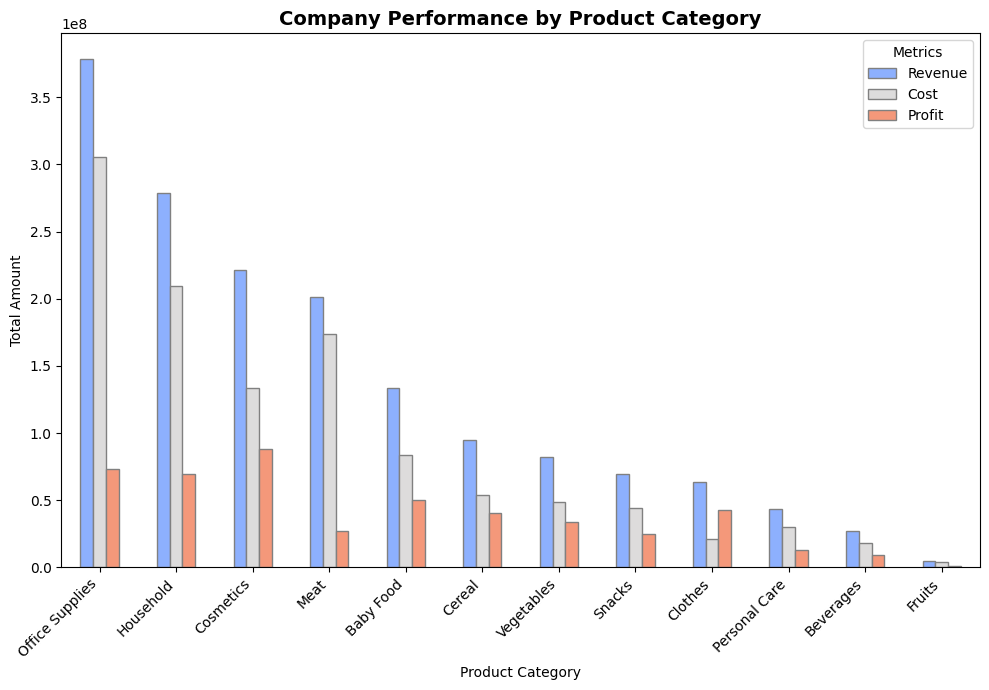

In [ ]:
plt.rcParams["figure.figsize"] = (10,7)

# Дохід, витрати, прибуток від продажів для Product Type
colors = sns.color_palette("coolwarm", n_colors=3)
category_product[["Revenue","Cost","Profit"]].plot(kind="bar", stacked=False, color=colors, edgecolor="grey")

plt.title("Company Performance by Product Category", fontsize=14, fontweight="bold")
plt.ylabel("Total Amount", fontsize=10)
plt.xlabel("Product Category", fontsize=10)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Metrics")

plt.tight_layout()
plt.show()

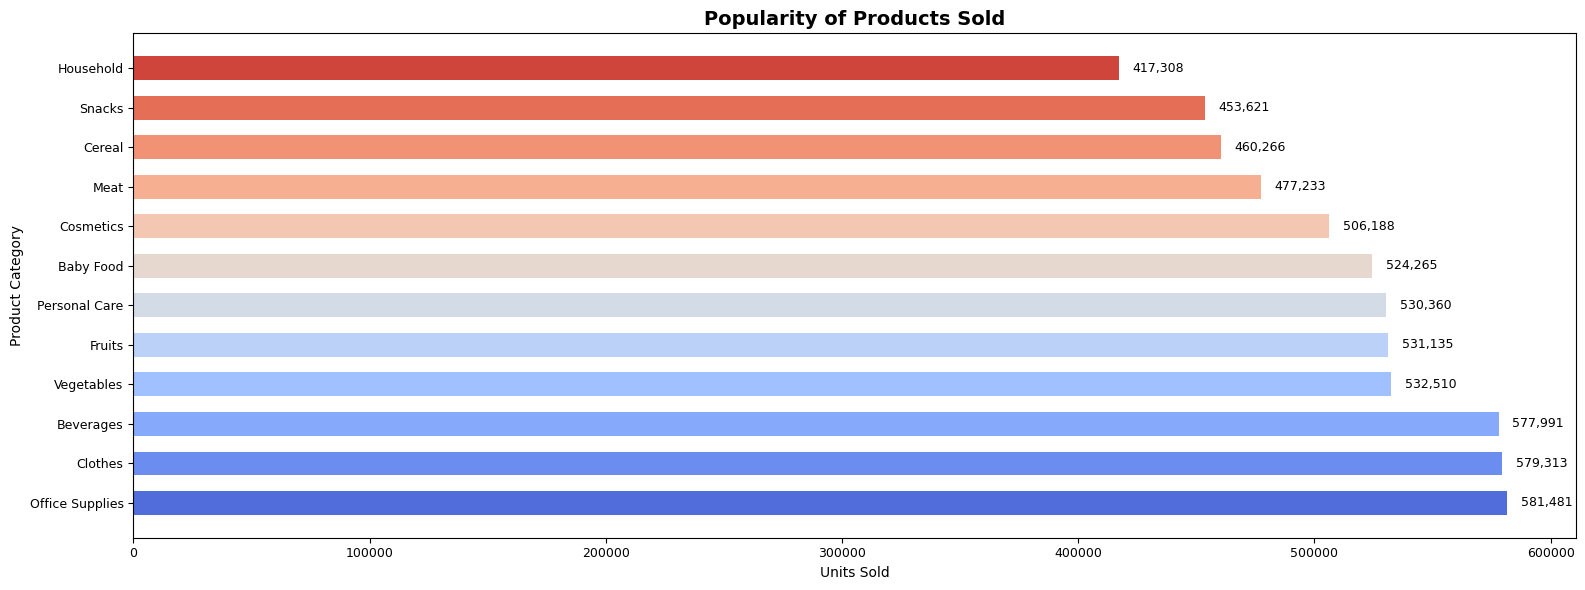

In [ ]:
# Візуалізація популярності (кількість проданих одиниць)
data = category_product[["Units Sold"]]
data_sorted = data.sort_values("Units Sold", ascending=False)
n = len(data_sorted)
colors = sns.color_palette("coolwarm", n_colors=n)

fig, ax = plt.subplots(figsize=(16, 6))

bars = ax.barh(data_sorted.index, data_sorted["Units Sold"], color=colors, height=0.6)

for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.01*data_sorted["Units Sold"].max(),
            bar.get_y() + bar.get_height()/2,
            f'{width:,.0f}',
            va="center",
            fontsize=9)

plt.title("Popularity of Products Sold", fontsize=14, fontweight="bold")
plt.ylabel("Product Category", fontsize=10)
plt.xlabel("Units Sold", fontsize=10)
plt.yticks(fontsize=9)
plt.xticks(fontsize=9)

plt.tight_layout()
plt.show()

## Згідно діаграми популярності товарів: найпопулярнішими за кількістю замовлень, являються Канцелярське приладдя та Одяг; найменш популярні Побутові речі. Що ж до показників діяльності, то: на першому місці знову ж таки Канцелярське приладдя за продажами та витратами; на другому Побутові речі; найменші показники у Фруктів; найбільший прибуток компанія отримала выд продажів Косметики.


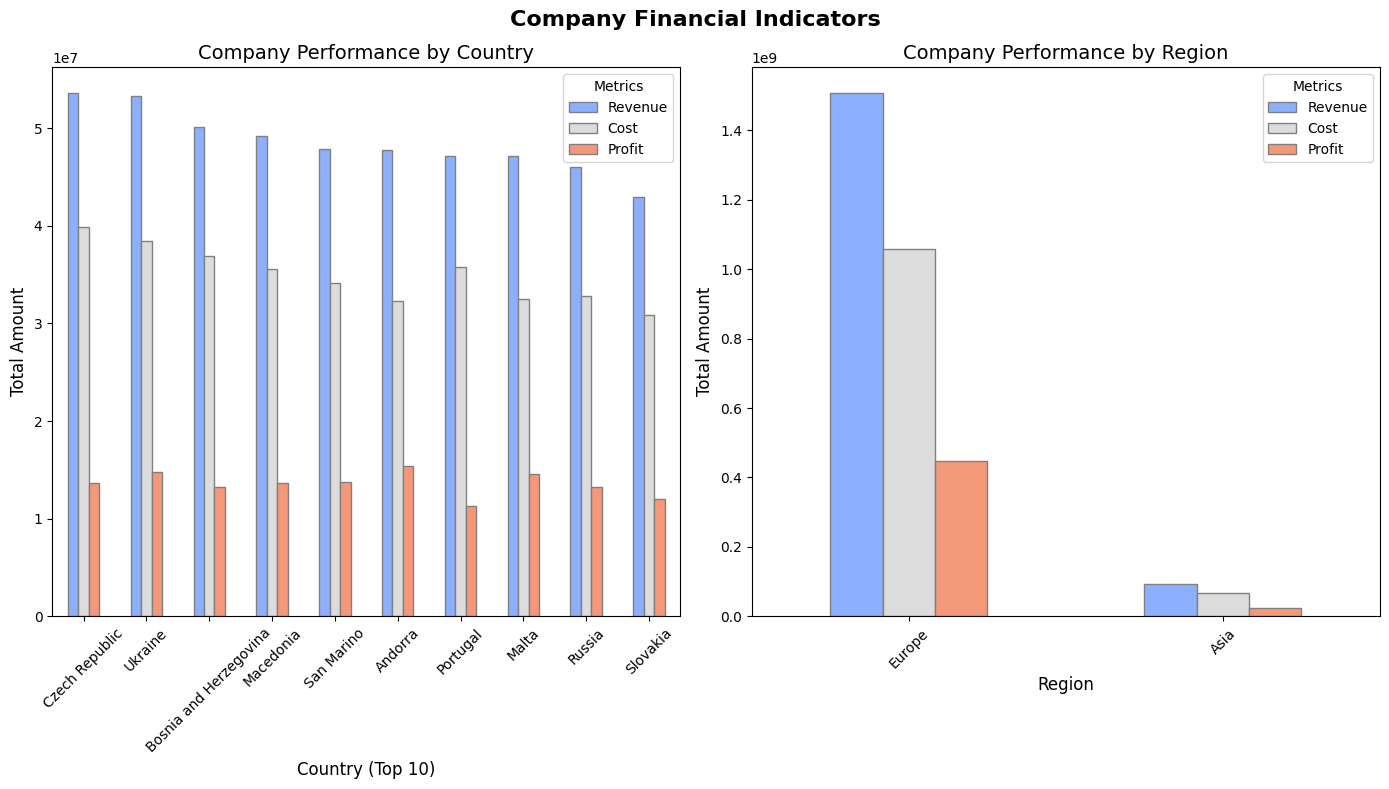

In [ ]:
# Аналіз по географії

#Топ 10
country_summary = df.groupby("Country").agg({
    "Revenue": "sum",
    "Cost": "sum",
    "Profit": "sum",
    "Units Sold": "sum"
}).sort_values("Revenue", ascending=False).head(10)

# По регіонах
region_summary = df.groupby("Region").agg({
    "Revenue": "sum",
    "Cost": "sum",
    "Profit": "sum",
    "Units Sold": "sum"
}).sort_values("Revenue", ascending=False)

# Колір
colors = sns.color_palette("coolwarm", n_colors=3)

# Фігура з двома підграфіками
fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=False)

# Два графіки
country_summary[["Revenue","Cost","Profit"]].plot(kind="bar", ax=axes[0], color=colors, edgecolor="grey")
axes[0].set_title("Company Performance by Country", fontsize=14)
axes[0].set_ylabel("Total Amount", fontsize=12)
axes[0].set_xlabel("Country (Top 10)", fontsize=12)
axes[0].tick_params(axis="x", rotation=45)
axes[0].legend(title="Metrics")

region_summary[["Revenue","Cost","Profit"]].plot(kind="bar", ax=axes[1], color=colors, edgecolor="grey")
axes[1].set_title("Company Performance by Region", fontsize=14)
axes[1].set_ylabel("Total Amount", fontsize=12)
axes[1].set_xlabel("Region", fontsize=12)
axes[1].tick_params(axis="x", rotation=45)
axes[1].legend(title="Metrics")

# Загальний стиль
plt.suptitle("Company Financial Indicators", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()


## В розрізі географії: 1. Европа перша по всім показникам діяльності (продажі, витрати, прибутки). 3. Чехія на першому місці по продажам та витратам, але за отриманим прибутком з продажу на першому місці Андорра. На останньому Словаччина.


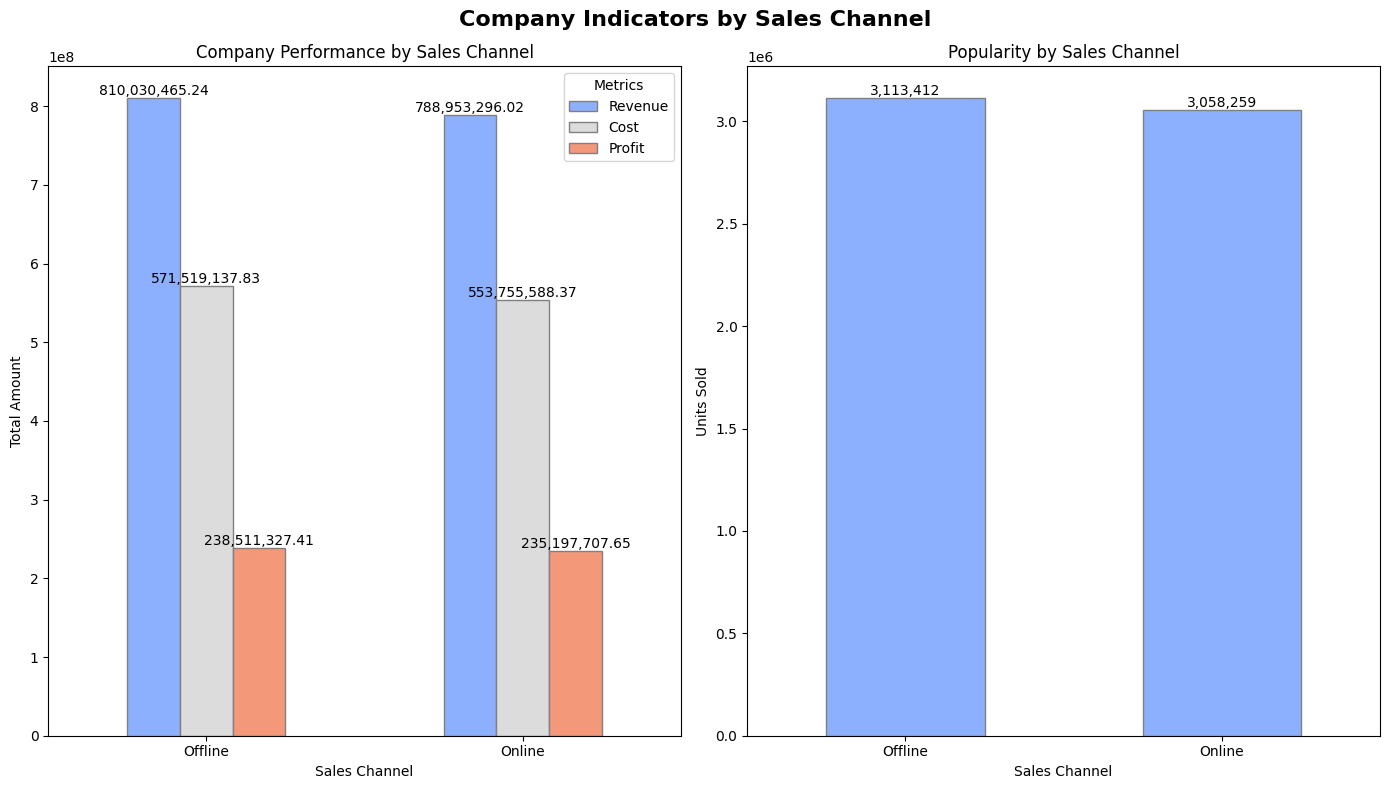

In [ ]:
# Аналіз по каналах продажу
channel_summary = df.groupby("Sales Channel").agg({
    "Revenue": "sum",
    "Cost": "sum",
    "Profit": "sum",
    "Units Sold": "sum"
})

# Колір
colors = sns.color_palette("coolwarm", n_colors=3)

# Фігура з двома підграфіками
fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=False)

# Робимо два графіки по каналам продожу: з основними метриками і по кількості проданих товарів
channel_summary[["Revenue","Cost","Profit"]].plot(kind="bar", ax=axes[0], color=colors, edgecolor="grey")
axes[0].set_title("Company Performance by Sales Channel", fontsize=12)
axes[0].set_ylabel("Total Amount", fontsize=10)
axes[0].set_xlabel("Sales Channel", fontsize=10)
axes[0].legend(title="Metrics")
axes[0].tick_params(axis="x", rotation=0)

# Підписи над стовпчиками
for p in axes[0].patches:
    height = p.get_height()
    axes[0].annotate(f'{height:,.2f}',
                     (p.get_x() + p.get_width() / 2, height),
                     ha="center",
                     va="bottom",
                     fontsize=10)

channel_summary[["Units Sold"]].plot(kind="bar", ax=axes[1], color=colors, edgecolor="grey", legend=False)
axes[1].set_title("Popularity by Sales Channel", fontsize=12)
axes[1].set_ylabel("Units Sold", fontsize=10)
axes[1].set_xlabel("Sales Channel", fontsize=10)
axes[1].tick_params(axis="x", rotation=0)

# Підписи над стовпчиками
for p in axes[1].patches:
    height = p.get_height()
    axes[1].annotate(f'{height:,.0f}',
                     (p.get_x() + p.get_width() / 2, height),
                     ha="center",
                     va="bottom",
                     fontsize=10)

# Загальний стиль
plt.suptitle("Company Indicators by Sales Channel", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()


## Більше продажів та отриманого прибутку через офлайн продажі, але загалом вони рухаються на однаковому рівні, адже різниця у замовленнях і їх кількості мінімальна.


/tmp/ipython-input-395225187.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Product Type", y="Shipping Time", data=df, order=product_order, ax=axes[0], palette=colors_product)
/tmp/ipython-input-395225187.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Country", y="Shipping Time", data=df[df["Country"].isin(top_countries)], order=top_countries, ax=axes[1], palette=colors_country)
/tmp/ipython-input-395225187.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Region", y="Shipping Time", data=df, order=region_order, ax=ax

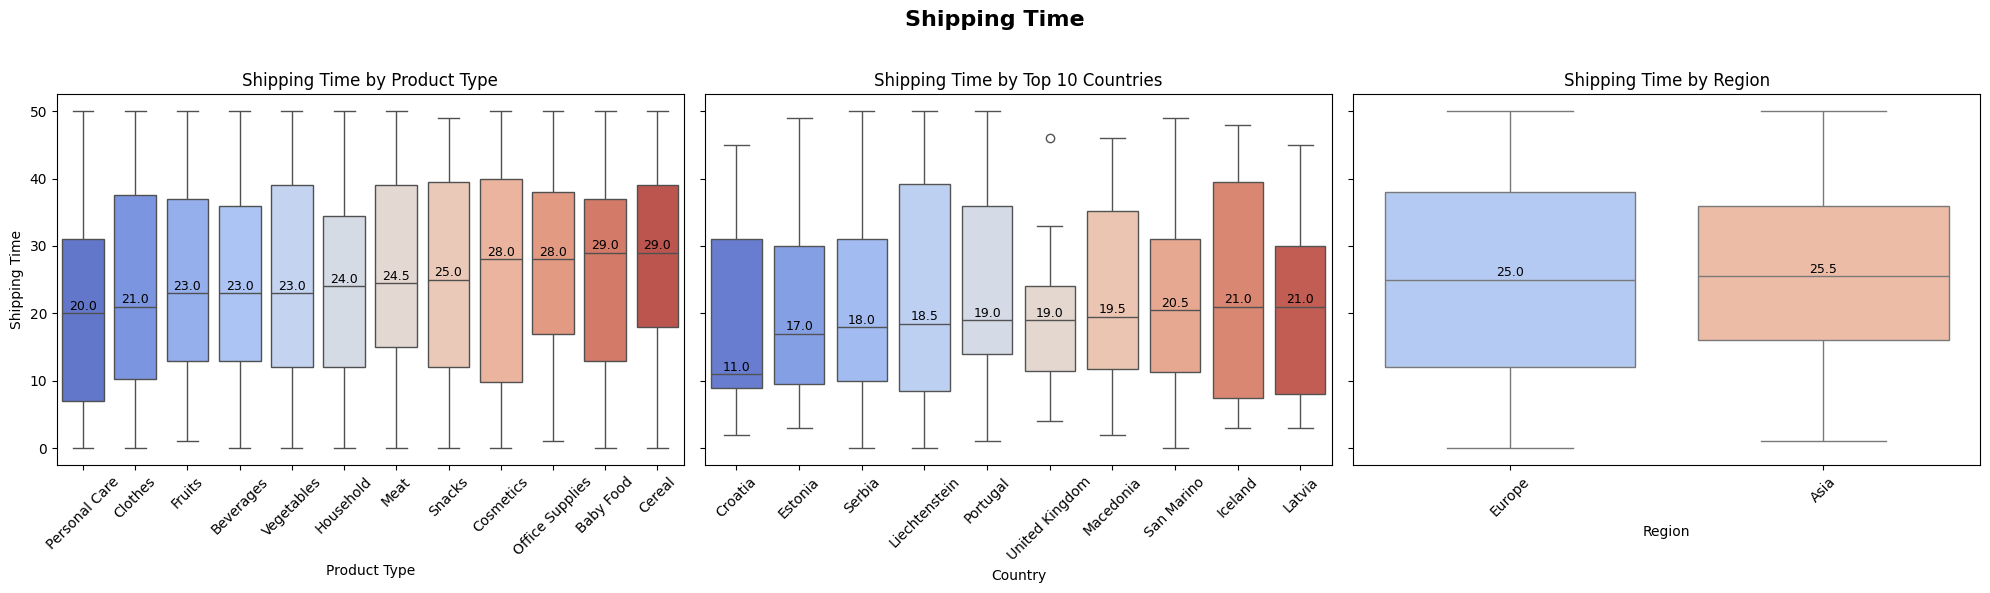

In [ ]:
# Інтервал часу між замовленням та його відвантаження

df["Shipping Time"] = (df["Ship Date"] - df["Order Date"]).dt.days

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# По категоріях товарів
product_order = df.groupby("Product Type")["Shipping Time"].median().sort_values().index
colors_product = sns.color_palette("coolwarm", n_colors=len(product_order))

sns.boxplot(x="Product Type", y="Shipping Time", data=df, order=product_order, ax=axes[0], palette=colors_product)
axes[0].set_title("Shipping Time by Product Type", fontsize=12)
axes[0].tick_params(axis="x", rotation=45)

# Підписи над стовпчиками
medians = df.groupby("Product Type")["Shipping Time"].median().loc[product_order]
for tick, label in enumerate(axes[0].get_xticklabels()):
    axes[0].text(tick, medians.iloc[tick] + 0.5,
                 round(medians.iloc[tick], 1),
                 ha="center",
                 color="black",
                 fontsize=9)

# По країнах
top_countries = df.groupby("Country")["Shipping Time"].median().sort_values().head(10).index
colors_country = sns.color_palette("coolwarm", n_colors=len(top_countries))

sns.boxplot(x="Country", y="Shipping Time", data=df[df["Country"].isin(top_countries)], order=top_countries, ax=axes[1], palette=colors_country)
axes[1].set_title("Shipping Time by Top 10 Countries", fontsize=12)
axes[1].tick_params(axis="x", rotation=45)


# Підписи над стовпчиками
medians = df.groupby("Country")["Shipping Time"].median().loc[top_countries]
for tick, label in enumerate(axes[1].get_xticklabels()):
    axes[1].text(tick, medians.iloc[tick] + 0.5,
                 round(medians.iloc[tick], 1),
                 ha="center",
                 color="black",
                 fontsize=9)

# 3. По регіонах
region_order = df.groupby("Region")["Shipping Time"].median().sort_values().index
colors_region = sns.color_palette("coolwarm", n_colors=len(region_order))

sns.boxplot(x="Region", y="Shipping Time", data=df, order=region_order, ax=axes[2], palette=colors_region)
axes[2].set_title("Shipping Time by Region", fontsize=12)
axes[2].tick_params(axis="x", rotation=45)

# Підписи над стовпчиками
medians = df.groupby("Region")["Shipping Time"].median().loc[region_order]
for tick, label in enumerate(axes[2].get_xticklabels()):
    axes[2].text(tick, medians.iloc[tick] + 0.5,
                 round(medians.iloc[tick], 1),
                 ha="center",
                 color="black",
                 fontsize=9)

plt.suptitle("Shipping Time", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


##  Найменша кількістів днів на доставку витрачається на Догляд (20 днів), а найбільше на Злаки (29 днів). Найбільший інтервал часу на відвантаження витрачається на Латвію (21 день), найменший на Хорватію (11 днів). Загалом, якщо брати категорії у розрізі регіонів, то найбільше на Азійський регіон - 25,5 днів, а на Європейський регіон - 25 днів.


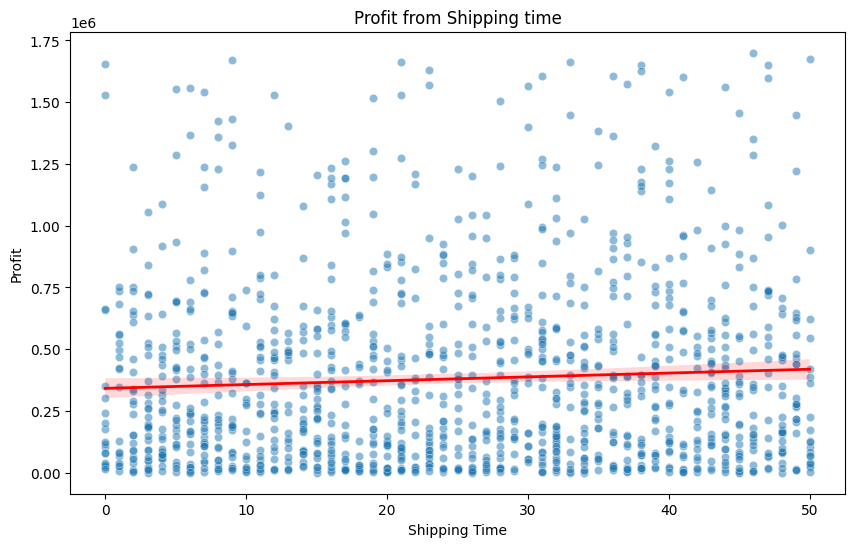

In [ ]:
# Прибуток від часу відвантаження

plt.figure(figsize=(10,6))

sns.scatterplot(x="Shipping Time", y="Profit", data=df, alpha=0.5)
sns.regplot(x="Shipping Time", y="Profit", data=df, scatter=False, color="red", line_kws={"lw":2})
plt.title("Profit from Shipping time")
plt.show()

## Чи залежить прибуток від часу, необхідного на відвантаження товару? В даному випадку, як такої прямої залежності немає. Хоча при довшому відвантаженню і більший прибуток, але треба дивитися по кількості замовлень, країнам і т.д.


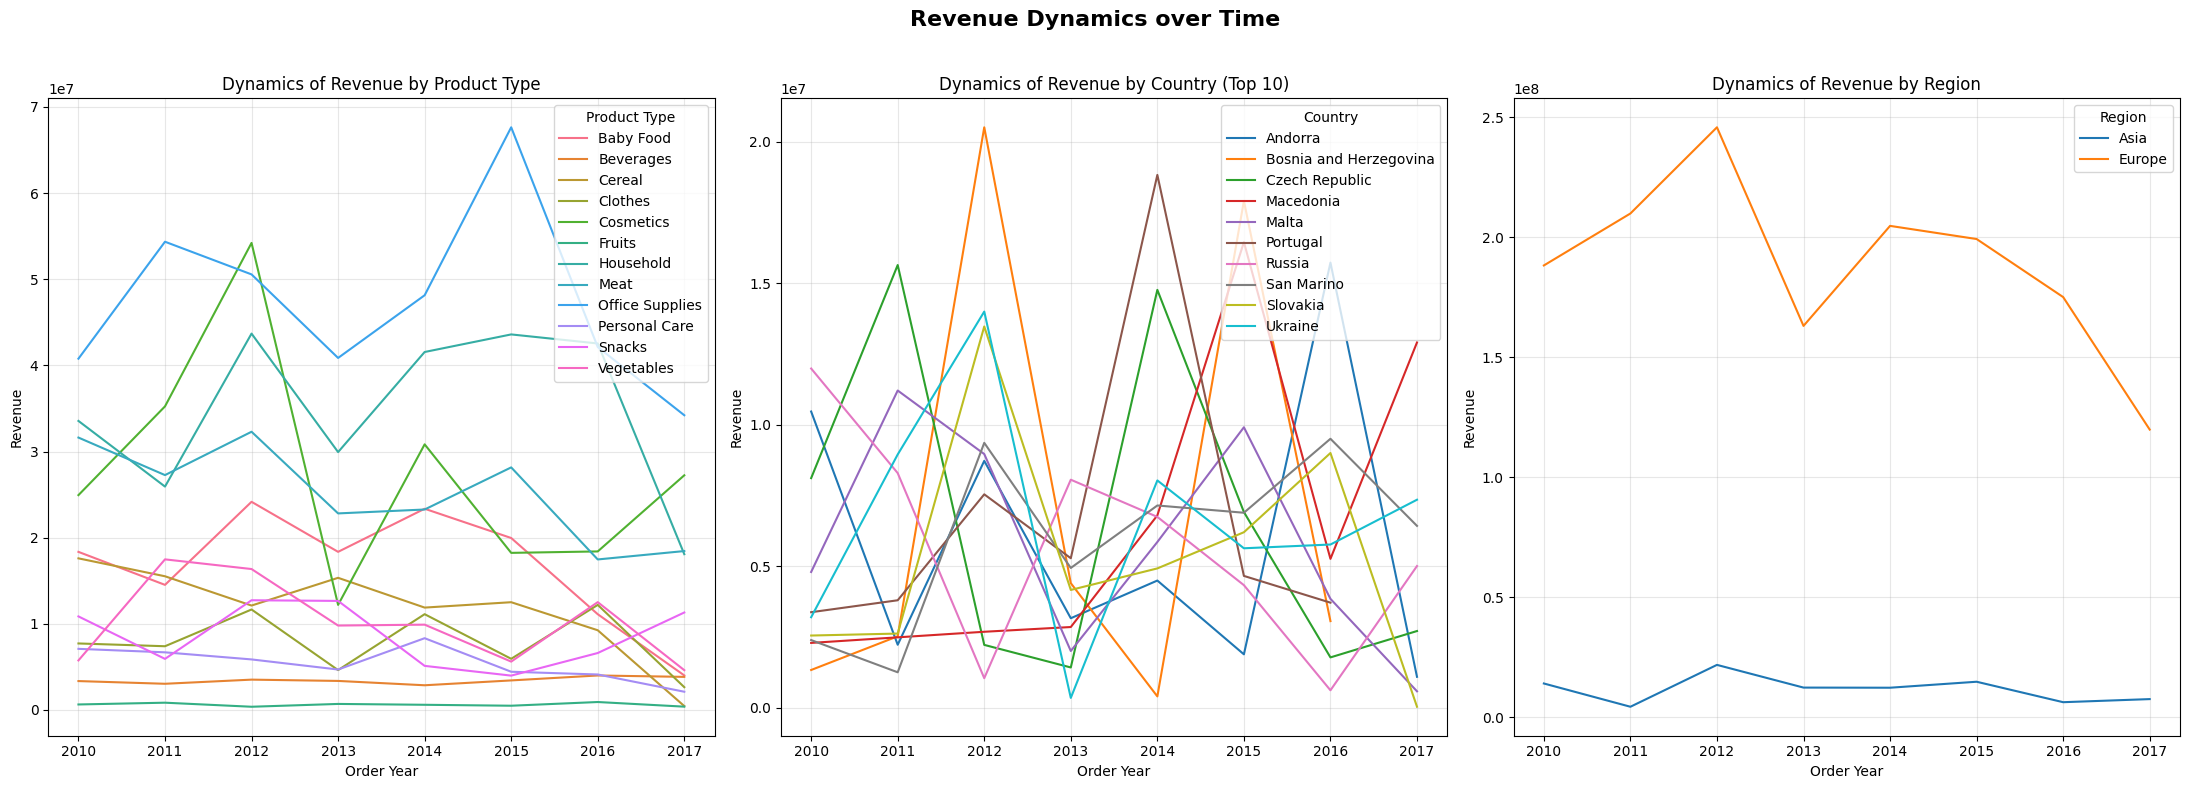

In [ ]:
# Перетворюємо дати у роки
df["Order Year"] = df["Order Date"].dt.year

# За категоріями
year_category = df.groupby(["Order Year", "Product Type"])["Revenue"].sum().reset_index()

# За країнами (топ-10)
top_countries = df.groupby("Country")["Revenue"].sum().nlargest(10).index
year_country = df[df["Country"].isin(top_countries)] \
    .groupby(["Order Year", "Country"])["Revenue"].sum().reset_index()

# За регіонами
year_region = df.groupby(["Order Year", "Region"])["Revenue"].sum().reset_index()


fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharex=True)

# Динаміка за категоріями
sns.lineplot(data=year_category, x="Order Year", y="Revenue", hue="Product Type", ax=axes[0])
axes[0].set_title("Dynamics of Revenue by Product Type", fontsize=12)
axes[0].set_ylabel("Revenue")
axes[0].grid(alpha=0.3)

# Динаміка за топ-10 країн
sns.lineplot(data=year_country, x="Order Year", y="Revenue", hue="Country", ax=axes[1])
axes[1].set_title("Dynamics of Revenue by Country (Top 10)", fontsize=12)
axes[1].set_ylabel("Revenue")
axes[1].grid(alpha=0.3)

# Динаміка за регіонами
sns.lineplot(data=year_region, x="Order Year", y="Revenue", hue="Region", ax=axes[2])
axes[2].set_title("Dynamics of Revenue by Region", fontsize=12)
axes[2].set_ylabel("Revenue")
axes[2].grid(alpha=0.3)

plt.suptitle("Revenue Dynamics over Time", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## По категоріям найбільша сума продажів у: Канцелярія за 2015р. та Косметика за 2012 р. По країнам: Боснія і Герцоговина найбільша сума продажів за 2012 р. та у Португалії - 2014 р. По регіонам найбільша сума продажів характерна для 2012 та 2014 років (Європейський регіон), 2012 р. (Азійський регіон). Основні тенденції: На високому рівні була Канцелярія, але в 2017 р. має спадну тенденцію. Пік продажів був у наприкінці 2011 р. по Побутовим речам, далі нестабільність і різке падіння у 2013 р., подальше відновлення 2014-2016 рр. та падіння у 2017 р. Косметика має пік продажів у 2012 р., але потім різке падіння, з подальшими спробами відновити рівень продажів і частково відновленим результатом у 2017 р.


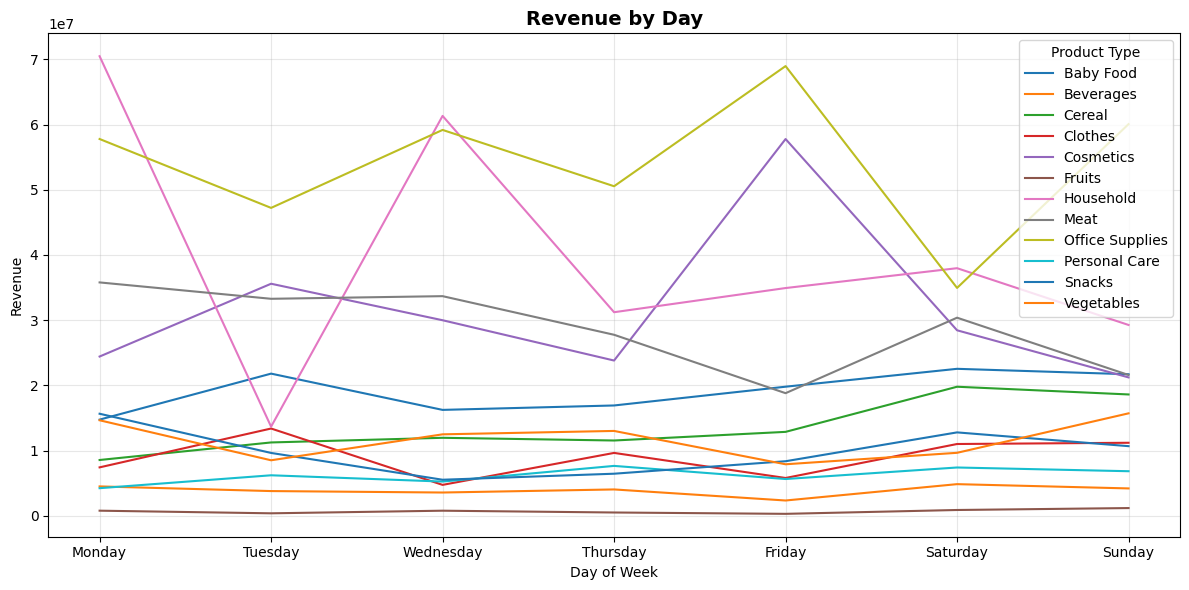

In [ ]:
# Перетворюємо дати у дні
df["Order Day"] = df["Order Date"].dt.day_name()

# За категоріями
day_category = df.groupby(["Order Day", "Product Type"])["Revenue"].sum().reset_index()

days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_category["Order Day"] = pd.Categorical(day_category["Order Day"], categories=days_order, ordered=True)

plt.figure(figsize=(12,6))

sns.lineplot(data=day_category, x="Order Day", y="Revenue", hue="Product Type", linewidth=1.5, palette="tab10")

plt.title("Revenue by Day", fontsize=14, fontweight="bold")
plt.ylabel("Revenue", fontsize=10)
plt.xlabel("Day of Week", fontsize=10)
plt.grid(alpha=0.3)
plt.xticks(rotation=0)
plt.legend(title="Product Type")
plt.tight_layout()
plt.show()

## Найбільша кількість продажів припадає на Понеділок по Побутовим речам, а найменше у Четверг. Канцелярія: П'ятниця (найбільше), Субота (найменше). Косметика: П'ятниця (найбільше), Неділя (Найменше).


Рекомендації для бізнесу:
- Підсилити маркетинг і пропозиції для Косметики, де маржа найвища;
- Для Канцелярії та Одягу варто оптимізувати логістику та запаси, бо попит високий, але прибуток не завжди пропорційний продажам;
- Розширювати присутність в Європі, особливо в країнах з високим прибутком;
- Аналізувати причини низької прибутковості у слабких ринках для покращення;
- Зменшувати час доставки для категорій із тривалим відвантаженням, щоб підвищити задоволення клієнтів;
- Планувати запаси під пікові дні тижня та сезонні тренди;
- Підсилити промоції у дні піків продажів для кожної категорії, що знаходиться у топах (наприклад, п’ятниця для Косметики і Канцелярії, понеділок для Побутових речей).